In [5]:
# HOME CREDIT DEFAULT RISK COMPETITION
# Most features are created by applying min, max, mean, sum and var functions to grouped tables. 
# Little feature selection is done and overfitting might be a problem since many features are related.
# The following key ideas were used:
# - Divide or subtract important features to get rates (like annuity and income)
# - In Bureau Data: create specific features for Active credits and Closed credits
# - In Previous Applications: create specific features for Approved and Refused applications
# - Modularity: one function for each table (except bureau_balance and application_test)
# - One-hot encoding for categorical features
# All tables are joined with the application DF using the SK_ID_CURR key (except bureau_balance).
# You can use LightGBM with KFold or Stratified KFold.

# Update 16/06/2018:
# - Added Payment Rate feature
# - Removed index from features
# - Use standard KFold CV (not stratified)

import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from lightgbm.callback import log_evaluation, early_stopping
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.simplefilter(action='ignore', category=FutureWarning)
import mlflow
from mlflow.models import infer_signature

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 31s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 41s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 22s
Installments payments df shape: (339587, 26)
Process installments payments - done in 45s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 26s
(356251, 798)
Starting LightGBM. Train shape: (307507, 798), test shape: (48744, 798)
Training until validation scores don't improve for 200 rounds
[200]	training's auc: 0.796879	training's binary_logloss: 0.234857	valid_1's auc: 0.776026	valid_1's binary_logloss: 0.246791
[400]	training's auc: 0.819227	training's binary_logloss: 0.225323	valid_1's auc: 0.786984	valid_1's binary_logloss: 0.242619
[600]	training's auc: 0.834105	training's binary_logloss: 0.219258	valid_1's auc: 0.790747	valid_1's binary_logloss: 0.241294
[800]	tr

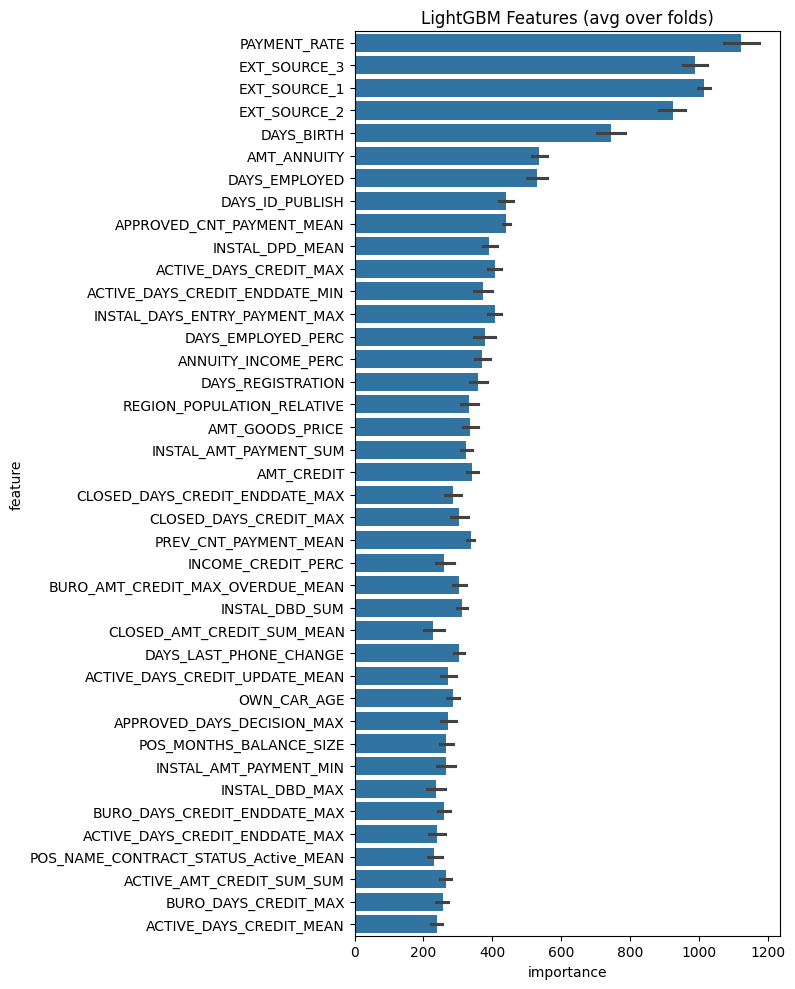

In [ ]:

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('input/application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('input/application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = pd.concat([df,test_df]).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH'] # taux de jours employés par rapport à l'âge
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT'] # 
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS'] # revenu par membre du foyer
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL'] # part de l'annuité par rapport au salaire total du client
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT'] # taux de paiement(somme remboursée) par rapport à la somme finale du crédit par année (previous application)
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('input/bureau.csv', nrows = num_rows)
    bb = pd.read_csv('input/bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
   
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('input/previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('input/POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('input/installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('input/credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg

# LightGBM GBDT with KFold or Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
def kfold_lightgbm(df, num_folds, stratified = False, debug= False):
    df = df.rename(columns = lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    print(df.shape)
    # Divide in training/validation and test data
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
    del df
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]

        # LightGBM parameters found by Bayesian optimization
        clf = LGBMClassifier(
            # **params_dict
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1,
        )

        # clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
        #     eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)
        train_x = convert_object_to_float(train_x)
        valid_x = convert_object_to_float(valid_x)
        test_df = convert_object_to_float(test_df)
        clf.fit(train_x, train_y, 
            eval_set=[(train_x, train_y), (valid_x, valid_y)],
            eval_metric='auc',
            callbacks=[early_stopping(200), log_evaluation(200)]
        )

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1] # out of fold
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        metric = roc_auc_score(valid_y, oof_preds[valid_idx])
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        # del clf, train_x, train_y, valid_x, valid_y
        # gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))
    # Write submission file and plot feature importance
    if not debug:
        test_df['TARGET'] = sub_preds
        test_df[['SK_ID_CURR', 'TARGET']].to_csv(submission_file_name, index= False)
    display_importances(feature_importance_df)

    # -------------------------------------------------------------------------------
    # Set MLflow Experiment ---------------------------------------------------------
    # mlflow.set_tracking_uri(uri="http://localhost:8080")
    # mlflow.set_experiment("lgbm_clf_credit_score_experiment")
    # with mlflow.start_run():
    #     params = {
    #         "nthread":6,
    #         "n_estimators":10000,
    #         "learning_rate":0.02,
    #         "num_leaves":34,
    #         "colsample_bytree":0.9497036,
    #         "subsample":0.8715623,
    #         "max_depth":8,
    #         "reg_alpha":0.041545473,
    #         "reg_lambda":0.0735294,
    #         "min_split_gain":0.0222415,
    #         "min_child_weight":39.3259775,
    #         "silent":-1,
    #         "verbose":-1
    #     }
    #     mlflow.log_params(params)

    #     # Log the loss metric
    #     mlflow.log_metric("accuracy", metric) # à renommer roc_auc
    #     # Set a tag that we can use to remind ourselves what this run was for
    #     mlflow.set_tag("Training Info", "LGBM Clf model for credit score")
    #     # Infer the model signature
    #     signature = infer_signature(train_x, clf.predict(train_x))
    #     # Log the model
    #     model_info = mlflow.sklearn.log_model(
    #         sk_model=clf,
    #         artifact_path="lgbm_credit_score",
    #         signature=signature,
    #         registered_model_name="lgbm_credit_score",
    #     )

    return feature_importance_df

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')


def convert_object_to_float(df):
    # Itérer sur les colonnes du dataframe
    for col in df.columns:
        # Vérifier si le type de la colonne est 'object'
        if df[col].dtype == 'object':
            try:
                # Convertir la colonne en type float
                df[col] = df[col].astype(float)
            except ValueError:
                print(f"Conversion failed for column: {col}")
    return df

def main(debug = False):
    num_rows = 10000 if debug else None
    df = application_train_test(num_rows)
    with timer("Process bureau and bureau_balance"):
        bureau = bureau_and_balance(num_rows)
        print("Bureau df shape:", bureau.shape)
        df = df.join(bureau, how='left', on='SK_ID_CURR')
        del bureau
        gc.collect()
    with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
    with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
    with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
    with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
    with timer("Run LightGBM with kfold"):
        feat_importance = kfold_lightgbm(df, num_folds= 10, stratified= False, debug= debug)

    print(f"df shape after preprocessing : {df.shape}")
    return df, feat_importance

if __name__ == "__main__":
    submission_file_name = "submission_kernel02.csv"
    with timer("Full model run"):
        df, feat_importance =  main(debug=False)


# Keep TOP 40 features in df


In [36]:
df_copy = df.copy()

In [37]:
Y = df_copy['TARGET']
df_copy.drop(labels='TARGET', axis=1, inplace=True)

In [40]:
feat_importance.to_csv('input/feat_importance.csv', encoding='utf-8', index=None)


In [27]:
# feat_importance.sort_values(by="importance", ascending=False)[:40]
top_features = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index.tolist()
top_features

['PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_EMPLOYED_PERC',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ANNUITY_INCOME_PERC',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'PREV_CNT_PAYMENT_MEAN',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'DAYS_LAST_PHONE_CHANGE',
 'CLOSED_DAYS_CREDIT_MAX',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'OWN_CAR_AGE',
 'APPROVED_DAYS_DECISION_MAX',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_SIZE',
 'INCOME_CREDIT_PERC',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'INSTAL_DBD_MAX',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'CLOSED_AMT_

In [29]:
df.columns.intersection(top_features)

Index(['AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_LAST_PHONE_CHANGE',
       'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'ANNUITY_INCOME_PERC',
       'PAYMENT_RATE', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ACTIVE_DAYS_CREDIT_MAX',
       'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
       'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
       'ACTIVE_AMT_CREDIT_SUM_SUM', 'CLOSED_DAYS_CREDIT_MAX',
       'CLOSED_DAYS_CREDIT_ENDDATE_MAX', 'CLOSED_AMT_CREDIT_SUM_MEAN',
       'PREV_CNT_PAYMENT_MEAN', 'APPROVED_DAYS_DECISION_MAX',
       'APPROVED_CNT_PAYMENT_MEAN', 'POS_MONTHS_BALANCE_SIZE',
       'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'INSTAL_DPD_MEAN',
       'INSTAL_DBD_MAX', 'INSTAL_DBD_SUM', 'I

In [41]:
df_final = df_copy[np.intersect1d(df_copy.columns, top_features)]


In [2]:
top_features

NameError: name 'top_features' is not defined

In [43]:
# add TARGET back
df_final['TARGET'] = Y

C:\Users\fly\AppData\Local\Temp\ipykernel_18932\2700169272.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['TARGET'] = Y


In [46]:
df_final.to_csv('input/df_final.csv', encoding='utf-8', index=None)


# Import DF Preprocessed and feature importance

In [6]:
df = pd.read_csv('data/df_preprocessed.csv')
feat_importance = pd.read_csv('input/feat_importance.csv')

In [9]:
df.SK_ID_CURR

0         100002
1         100003
2         100004
3         100006
4         100007
           ...  
356246    456221
356247    456222
356248    456223
356249    456224
356250    456250
Name: SK_ID_CURR, Length: 356251, dtype: int64

In [14]:
top_features = feat_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index.tolist()
top_features = ['SK_ID_CURR', 'TARGET'] + top_features
top_features

['SK_ID_CURR',
 'TARGET',
 'PAYMENT_RATE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_3',
 'EXT_SOURCE_2',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'DAYS_EMPLOYED',
 'APPROVED_CNT_PAYMENT_MEAN',
 'DAYS_ID_PUBLISH',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'ACTIVE_DAYS_CREDIT_MAX',
 'INSTAL_DPD_MEAN',
 'DAYS_EMPLOYED_PERC',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ANNUITY_INCOME_PERC',
 'DAYS_REGISTRATION',
 'AMT_CREDIT',
 'PREV_CNT_PAYMENT_MEAN',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DBD_SUM',
 'DAYS_LAST_PHONE_CHANGE',
 'CLOSED_DAYS_CREDIT_MAX',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'OWN_CAR_AGE',
 'APPROVED_DAYS_DECISION_MAX',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'ACTIVE_AMT_CREDIT_SUM_SUM',
 'POS_MONTHS_BALANCE_SIZE',
 'INCOME_CREDIT_PERC',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'INSTAL_DBD_MAX',
 'POS_NAME_CONTRACT_STATUS_A

In [15]:
df_final = df[np.intersect1d(df.columns, top_features)]

In [18]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ACTIVE_AMT_CREDIT_SUM_SUM             251811 non-null  float64
 1   ACTIVE_DAYS_CREDIT_ENDDATE_MAX        241342 non-null  float64
 2   ACTIVE_DAYS_CREDIT_ENDDATE_MIN        241342 non-null  float64
 3   ACTIVE_DAYS_CREDIT_MAX                251811 non-null  float64
 4   ACTIVE_DAYS_CREDIT_MEAN               251811 non-null  float64
 5   ACTIVE_DAYS_CREDIT_UPDATE_MEAN        251811 non-null  float64
 6   AMT_ANNUITY                           356215 non-null  float64
 7   AMT_CREDIT                            356251 non-null  float64
 8   AMT_GOODS_PRICE                       355973 non-null  float64
 9   ANNUITY_INCOME_PERC                   356215 non-null  float64
 10  APPROVED_CNT_PAYMENT_MEAN             337694 non-null  float64
 11  

In [19]:
# Replace missing values by 0
df_final.isna().mean()*100

ACTIVE_AMT_CREDIT_SUM_SUM               29.316409
ACTIVE_DAYS_CREDIT_ENDDATE_MAX          32.255067
ACTIVE_DAYS_CREDIT_ENDDATE_MIN          32.255067
ACTIVE_DAYS_CREDIT_MAX                  29.316409
ACTIVE_DAYS_CREDIT_MEAN                 29.316409
ACTIVE_DAYS_CREDIT_UPDATE_MEAN          29.316409
AMT_ANNUITY                              0.010105
AMT_CREDIT                               0.000000
AMT_GOODS_PRICE                          0.078035
ANNUITY_INCOME_PERC                      0.010105
APPROVED_CNT_PAYMENT_MEAN                5.208968
APPROVED_DAYS_DECISION_MAX               5.208968
BURO_AMT_CREDIT_MAX_OVERDUE_MEAN        40.219957
BURO_DAYS_CREDIT_ENDDATE_MAX            14.885292
BURO_DAYS_CREDIT_MAX                    14.159680
CLOSED_AMT_CREDIT_SUM_MEAN              24.794316
CLOSED_DAYS_CREDIT_ENDDATE_MAX          25.286385
CLOSED_DAYS_CREDIT_MAX                  24.794316
DAYS_BIRTH                               0.000000
DAYS_EMPLOYED                           18.146756


In [23]:
cols_with_missing_values = [col for col in df_final.columns if df_final[col].isnull().mean() > 0 and 'TARGET' not in col] 
cols_with_missing_values

['ACTIVE_AMT_CREDIT_SUM_SUM',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX',
 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
 'ACTIVE_DAYS_CREDIT_MAX',
 'ACTIVE_DAYS_CREDIT_MEAN',
 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'ANNUITY_INCOME_PERC',
 'APPROVED_CNT_PAYMENT_MEAN',
 'APPROVED_DAYS_DECISION_MAX',
 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'BURO_DAYS_CREDIT_MAX',
 'CLOSED_AMT_CREDIT_SUM_MEAN',
 'CLOSED_DAYS_CREDIT_ENDDATE_MAX',
 'CLOSED_DAYS_CREDIT_MAX',
 'DAYS_EMPLOYED',
 'DAYS_EMPLOYED_PERC',
 'DAYS_LAST_PHONE_CHANGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'INSTAL_AMT_PAYMENT_MIN',
 'INSTAL_AMT_PAYMENT_SUM',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'INSTAL_DBD_MAX',
 'INSTAL_DBD_SUM',
 'INSTAL_DPD_MEAN',
 'OWN_CAR_AGE',
 'PAYMENT_RATE',
 'POS_MONTHS_BALANCE_SIZE',
 'POS_NAME_CONTRACT_STATUS_Active_MEAN',
 'PREV_CNT_PAYMENT_MEAN']

In [24]:
for col in cols_with_missing_values:
    df_final[col] = df_final[col].fillna(0)

C:\Users\fly\AppData\Local\Temp\ipykernel_4636\2286518556.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final[col] = df_final[col].fillna(0)


In [25]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 356251 entries, 0 to 356250
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ACTIVE_AMT_CREDIT_SUM_SUM             356251 non-null  float64
 1   ACTIVE_DAYS_CREDIT_ENDDATE_MAX        356251 non-null  float64
 2   ACTIVE_DAYS_CREDIT_ENDDATE_MIN        356251 non-null  float64
 3   ACTIVE_DAYS_CREDIT_MAX                356251 non-null  float64
 4   ACTIVE_DAYS_CREDIT_MEAN               356251 non-null  float64
 5   ACTIVE_DAYS_CREDIT_UPDATE_MEAN        356251 non-null  float64
 6   AMT_ANNUITY                           356251 non-null  float64
 7   AMT_CREDIT                            356251 non-null  float64
 8   AMT_GOODS_PRICE                       356251 non-null  float64
 9   ANNUITY_INCOME_PERC                   356251 non-null  float64
 10  APPROVED_CNT_PAYMENT_MEAN             356251 non-null  float64
 11  

In [26]:
df_final.to_csv('data/df_final.csv', encoding='utf-8', index=None)